In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# --- Configuration ---
# !!! IMPORTANT !!!
# Please update this variable to the name of your target column.
# This is the column with the 'high', 'medium', 'low' safety labels.
TARGET_COLUMN = 'Safety'  # <--- CHANGE THIS IF NEEDED

# List of columns to drop (e.g., identifiers, irrelevant data)
# 'Image Name' and 'Time' seem like identifiers, but you can change this.
DROP_COLUMNS = ['Image Name']

# File path
FILE_PATH = 'concatenated_file(3).csv'

# Test size for 80-20 split
TEST_SPLIT_SIZE = 0.2
# --- End Configuration ---

def load_and_prepare_data(filepath, target_col, drop_cols):
    """
    Loads data, separates features and target, and splits into train/test sets.
    """
    try:
        data = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

    if target_col not in data.columns:
        print(f"Error: Target column '{target_col}' not found in the CSV.")
        print(f"Available columns are: {list(data.columns)}")
        print("Please update the 'TARGET_COLUMN' variable in the script.")
        return None

    # Drop specified columns
    X = data.drop(columns=[target_col] + drop_cols, errors='ignore')
    y_raw = data[target_col]

    # Encode the target variable (e.g., 'low', 'medium', 'high' -> 0, 1, 2)
    le = LabelEncoder()
    y = le.fit_transform(y_raw)

    print(f"Target variable '{target_col}' encoded.")
    print("Original labels:", le.classes_)
    print("Encoded labels:", np.unique(y))

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SPLIT_SIZE,
        random_state=42,
        stratify=y  # Stratify to ensure class balance in splits
    )

    print(f"Data split into {100 * (1 - TEST_SPLIT_SIZE)}% training and {100 * TEST_SPLIT_SIZE}% testing.")
    return X_train, X_test, y_train, y_test, X.columns, le.classes_

def create_preprocessing_pipeline(features_df):
    """
    Creates a preprocessing pipeline to handle numerical and categorical features.
    """
    # Identify numerical and categorical features
    # We select columns based on data type from the training set
    numeric_features = features_df.select_dtypes(include=np.number).columns.tolist()
    categorical_features = features_df.select_dtypes(include=['object', 'category']).columns.tolist()

    print(f"\nIdentified {len(numeric_features)} numeric features.")
    print(f"Identified {len(categorical_features)} categorical features.")

    # Create preprocessing steps for numerical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Fill missing values
        ('scaler', StandardScaler())                  # Scale data
    ])

    # Create preprocessing steps for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # Fill missing values
        ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-hot encode
    ])

    # Combine transformers using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough' # Keep any columns not specified
    )

    return preprocessor

def build_and_train_model(X_train, y_train):
    """
    Builds the full pipeline including preprocessing and the model,
    and then trains it.
    """
    print("\nBuilding preprocessing and model pipeline...")
    preprocessor = create_preprocessing_pipeline(X_train)

    # Create the full pipeline
    # 1. Preprocess data
    # 2. Train Logistic Regression model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            multi_class='auto', # Handle multi-class (low, medium, high)
            solver='lbfgs',
            max_iter=1000,      # Increase iterations for convergence
            random_state=42
        ))
    ])

    print("Training the model...")
    pipeline.fit(X_train, y_train)
    print("Model training complete.")

    return pipeline

def evaluate_model(pipeline, X_test, y_test, target_names):
    """
    Evaluates the trained model on the test set and prints metrics.
    """
    print("\n--- Model Evaluation ---")

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    print("Rows: True Label, Columns: Predicted Label")
    cm = confusion_matrix(y_test, y_pred)

    # Pretty print confusion matrix
    print(f"{'':<10}", end="")
    for name in target_names:
        print(f"{name:<10}", end="")
    print()
    print("-" * (10 * (len(target_names) + 1)))

    for i, row in enumerate(cm):
        print(f"{target_names[i]:<10}", end="")
        for val in row:
            print(f"{val:<10}", end="")
        print()

def main():
    """
    Main function to run the data loading, training, and evaluation.
    """
    prepared_data = load_and_prepare_data(FILE_PATH, TARGET_COLUMN, DROP_COLUMNS)

    if prepared_data is None:
        return

    X_train, X_test, y_train, y_test, feature_names, target_names = prepared_data

    model_pipeline = build_and_train_model(X_train, y_train)

    evaluate_model(model_pipeline, X_test, y_test, target_names)

if __name__ == "__main__":
    main()

Target variable 'Safety' encoded.
Original labels: ['High' 'Low' 'Medium']
Encoded labels: [0 1 2]
Data split into 80.0% training and 20.0% testing.

Building preprocessing and model pipeline...

Identified 513 numeric features.
Identified 4 categorical features.
Training the model...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Model training complete.

--- Model Evaluation ---
Accuracy: 70.11%

Classification Report:
              precision    recall  f1-score   support

        High       0.82      0.85      0.84        66
         Low       0.25      0.20      0.22         5
      Medium       0.27      0.25      0.26        16

    accuracy                           0.70        87
   macro avg       0.45      0.43      0.44        87
weighted avg       0.69      0.70      0.69        87


Confusion Matrix:
Rows: True Label, Columns: Predicted Label
          High      Low       Medium    
----------------------------------------
High      56        1         9         
Low       2         1         2         
Medium    10        2         4         


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier  # <--- Import KNN
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# --- Configuration ---
# !!! IMPORTANT !!!
# Please update this variable to the name of your target column.
# This is the column with the 'high', 'medium', 'low' safety labels.
TARGET_COLUMN = 'Safety'  # <--- CHANGE THIS IF NEEDED

# List of columns to drop (e.g., identifiers, irrelevant data)
# 'Image Name' and 'Time' seem like identifiers, but you can change this.
DROP_COLUMNS = ['Image Name']

# File path
FILE_PATH = 'concatenated_file(3).csv'

# Test size for 80-20 split
TEST_SPLIT_SIZE = 0.2
# --- End Configuration ---

def load_and_prepare_data(filepath, target_col, drop_cols):
    """
    Loads data, separates features and target, and splits into train/test sets.
    """
    try:
        data = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

    if target_col not in data.columns:
        print(f"Error: Target column '{target_col}' not found in the CSV.")
        print(f"Available columns are: {list(data.columns)}")
        print("Please update the 'TARGET_COLUMN' variable in the script.")
        return None

    # Drop specified columns
    X = data.drop(columns=[target_col] + drop_cols, errors='ignore')
    y_raw = data[target_col]

    # Encode the target variable (e.g., 'low', 'medium', 'high' -> 0, 1, 2)
    le = LabelEncoder()
    y = le.fit_transform(y_raw)

    print(f"Target variable '{target_col}' encoded.")
    print("Original labels:", le.classes_)
    print("Encoded labels:", np.unique(y))

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SPLIT_SIZE,
        random_state=42,
        stratify=y  # Stratify to ensure class balance in splits
    )

    print(f"Data split into {100 * (1 - TEST_SPLIT_SIZE)}% training and {100 * TEST_SPLIT_SIZE}% testing.")
    return X_train, X_test, y_train, y_test, X.columns, le.classes_

def create_preprocessing_pipeline(features_df):
    """
    Creates a preprocessing pipeline to handle numerical and categorical features.
    """
    # Identify numerical and categorical features
    numeric_features = features_df.select_dtypes(include=np.number).columns.tolist()
    categorical_features = features_df.select_dtypes(include=['object', 'category']).columns.tolist()

    print(f"\nIdentified {len(numeric_features)} numeric features.")
    print(f"Identified {len(categorical_features)} categorical features.")

    # Create preprocessing steps for numerical features
    # StandardScaler is very important for KNN
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Fill missing values
        ('scaler', StandardScaler())                  # Scale data
    ])

    # Create preprocessing steps for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # Fill missing values
        ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-hot encode
    ])

    # Combine transformers using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough' # Keep any columns not specified
    )

    return preprocessor

def build_and_train_model(X_train, y_train):
    """
    Builds the full pipeline including preprocessing and the model,
    and then trains it.
    """
    print("\nBuilding preprocessing and model pipeline...")
    preprocessor = create_preprocessing_pipeline(X_train)

    # Create the full pipeline
    # 1. Preprocess data
    # 2. Train K-Nearest Neighbors model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(
            n_neighbors=5  # Default number of neighbors, can be tuned
        ))
    ])

    print("Training the KNN model...")
    pipeline.fit(X_train, y_train)
    print("Model training complete.")

    return pipeline

def evaluate_model(pipeline, X_test, y_test, target_names):
    """
    Evaluates the trained model on the test set and prints metrics.
    """
    print("\n--- Model Evaluation ---")

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Print the classifier model details
    print("\n--- Trained Model Details ---")
    # 'classifier' is the name we gave the KNeighborsClassifier step in the pipeline
    try:
        print(pipeline.named_steps['classifier'])
    except KeyError:
        print("Could not find 'classifier' step in pipeline.")
    print("-----------------------------")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    print("Rows: True Label, Columns: Predicted Label")
    cm = confusion_matrix(y_test, y_pred)

    # Pretty print confusion matrix
    print(f"{'':<10}", end="")
    for name in target_names:
        print(f"{name:<10}", end="")
    print()
    print("-" * (10 * (len(target_names) + 1)))

    for i, row in enumerate(cm):
        print(f"{target_names[i]:<10}", end="")
        for val in row:
            print(f"{val:<10}", end="")
        print()

def main():
    """
    Main function to run the data loading, training, and evaluation.
    """
    prepared_data = load_and_prepare_data(FILE_PATH, TARGET_COLUMN, DROP_COLUMNS)

    if prepared_data is None:
        return

    X_train, X_test, y_train, y_test, feature_names, target_names = prepared_data

    model_pipeline = build_and_train_model(X_train, y_train)

    evaluate_model(model_pipeline, X_test, y_test, target_names)

if __name__ == "__main__":
    main()

Target variable 'Safety' encoded.
Original labels: ['High' 'Low' 'Medium']
Encoded labels: [0 1 2]
Data split into 80.0% training and 20.0% testing.

Building preprocessing and model pipeline...

Identified 513 numeric features.
Identified 4 categorical features.
Training the KNN model...
Model training complete.

--- Model Evaluation ---
Accuracy: 71.26%

--- Trained Model Details ---
KNeighborsClassifier()
-----------------------------

Classification Report:
              precision    recall  f1-score   support

        High       0.76      0.92      0.84        66
         Low       0.00      0.00      0.00         5
      Medium       0.17      0.06      0.09        16

    accuracy                           0.71        87
   macro avg       0.31      0.33      0.31        87
weighted avg       0.61      0.71      0.65        87


Confusion Matrix:
Rows: True Label, Columns: Predicted Label
          High      Low       Medium    
----------------------------------------
High     

In [ ]:
import matplotlib.pyplot as plt

# Define a range of k values to iterate through
k_values = range(1, 51)  # Changed range to 1 to 50

# Initialize lists to store error rates

test_errors = []

print("Evaluating KNN for different k values...")

for k_value in k_values:
    # a. Instantiate a KNeighborsClassifier with n_neighbors set to the current k_value
    knn = KNeighborsClassifier(n_neighbors=k_value)

    # b. Train the KNN model
    knn.fit(X_train_processed, y_train)

    # c. Predict the labels for training and testing data
    y_train_pred = knn.predict(X_train_processed)
    y_test_pred = knn.predict(X_test_processed)

    # d. Calculate training accuracy and error
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_error = 1 - train_accuracy
    train_errors.append(train_error)

    # e. Calculate testing accuracy and error
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_error = 1 - test_accuracy
    test_errors.append(test_error)

    print(f"k={k_value}:  Test Error = {test_error:.4f}")

print("\nKNN evaluation for various k values complete.")

Evaluating KNN for different k values...
k=1:  Test Error = 0.3448
k=2:  Test Error = 0.2759
k=3:  Test Error = 0.2989
k=4:  Test Error = 0.2874
k=5:  Test Error = 0.2759
k=6:  Test Error = 0.2414
k=7:  Test Error = 0.2529
k=8:  Test Error = 0.2529
k=9:  Test Error = 0.2299
k=10:  Test Error = 0.2414
k=11:  Test Error = 0.2414
k=12:  Test Error = 0.2299
k=13:  Test Error = 0.2299
k=14:  Test Error = 0.2299
k=15:  Test Error = 0.2299
k=16:  Test Error = 0.2299
k=17:  Test Error = 0.2299
k=18:  Test Error = 0.2299
k=19:  Test Error = 0.2299
k=20:  Test Error = 0.2299
k=21:  Test Error = 0.2299
k=22:  Test Error = 0.2299
k=23:  Test Error = 0.2299
k=24:  Test Error = 0.2299
k=25:  Test Error = 0.2414
k=26:  Test Error = 0.2414
k=27:  Test Error = 0.2529
k=28:  Test Error = 0.2299
k=29:  Test Error = 0.2299
k=30:  Test Error = 0.2414
k=31:  Test Error = 0.2299
k=32:  Test Error = 0.2414
k=33:  Test Error = 0.2414
k=34:  Test Error = 0.2414
k=35:  Test Error = 0.2414
k=36:  Test Error = 0.2

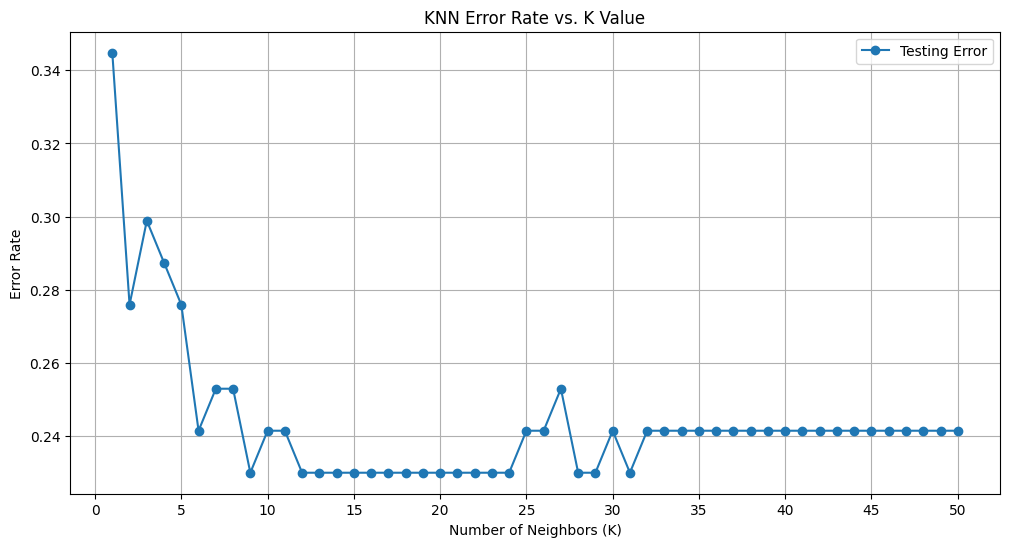

Plotting KNN error rates for various k values (without training error).


In [ ]:
plt.figure(figsize=(12, 6))
# plt.plot(k_values, train_errors, marker='o', label='Training Error') # Removed train error plot
plt.plot(k_values, test_errors, marker='o', label='Testing Error')
plt.title('KNN Error Rate vs. K Value')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Error Rate')
plt.locator_params(axis='x', nbins=20) # Adjust x-axis ticks for readability with larger range
plt.grid(True)
plt.legend()
plt.show()

print("Plotting KNN error rates for various k values (without training error).")